In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes

In [2]:
time = ['2018-11-13T00:00:00Z', '2018-11-14T00:00:00Z']

file_name = f"./data/psp_{time[0]}_{time[1]}_fit.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('PSP_SWP_SPC_L3I', ['vp_fit_RTN_gd', 'np_fit_gd'], time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = data.vp_fit_RTN.values
    velocity[np.any(velocity == data.vp_fit_RTN.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime))
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values
    velocity = velocity.values

    density = data.np_fit.values
    density[density == data.np_fit.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime))
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate().values

    status, data = cdas.get_data('PSP_FLD_L2_MAG_RTN', ['psp_fld_l2_mag_RTN'], time[0], time[1])

    magnetic_field = data.psp_fld_l2_mag_RTN.values
    magnetic_field[np.any(magnetic_field == data.psp_fld_l2_mag_RTN.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.epoch_mag_RTN.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime))
    magnetic_field = magnetic_field.resample("60s").mean().shift(0.5, freq="60s").interpolate().values
    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
times = data["times"]

In [3]:
durations = range(10, 170)
gas_pressure = torch.zeros_like(density)
results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size=256,
                            window_steps=[max(duration // 16, 1) for duration in durations],
                            window_lengths=durations,
                            min_strength=25,
                            frame_type="vht",
                            threshold_flow_field_alignment=0.8,
                            max_processing_resolution=64)

100%|██████████| 160/160 [00:01<00:00, 107.00it/s]


In [4]:
print(len(results), 'detected')

14 detected


2018-11-13T01:16:30.000000000  to  2018-11-13T01:28:30.000000000
duration: 13
error: 0.116 0.121
walen slope: 0.669
<B>: 31.74
Altitude/azimuth: 78 / 141
Frame quality: 0.9971880555690502
Field-alignedness 0.9852458238601685


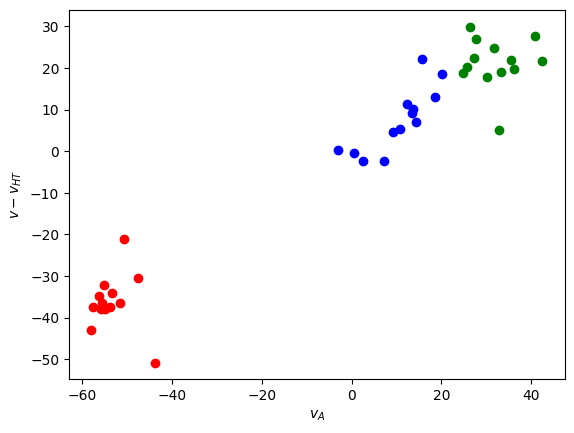

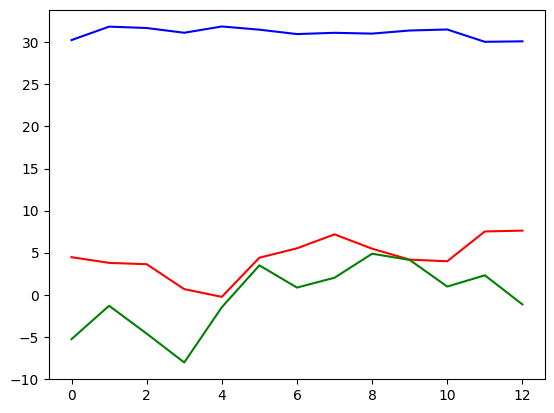

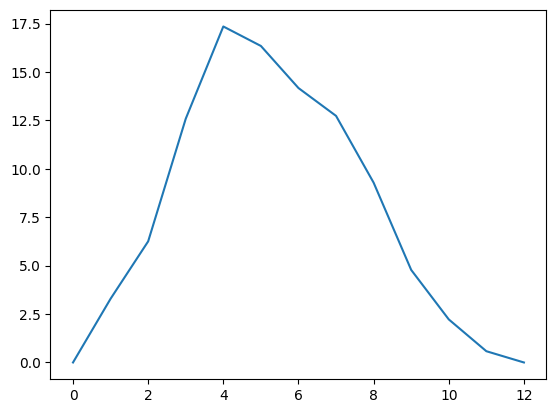

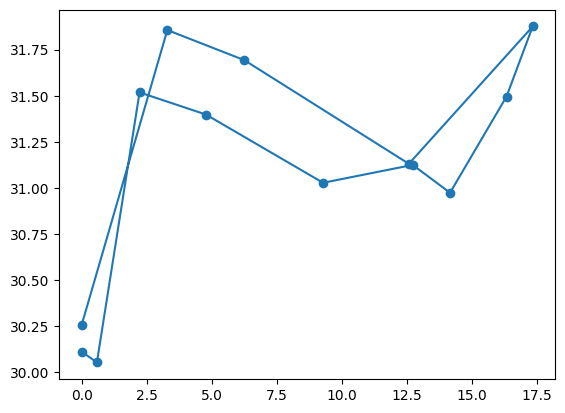

2018-11-13T02:05:30.000000000  to  2018-11-13T02:18:30.000000000
duration: 14
error: 0.111 0.128
walen slope: 0.615
<B>: 29.87
Altitude/azimuth: 94 / 165
Frame quality: 0.9975069106907932
Field-alignedness 0.8868995010852814


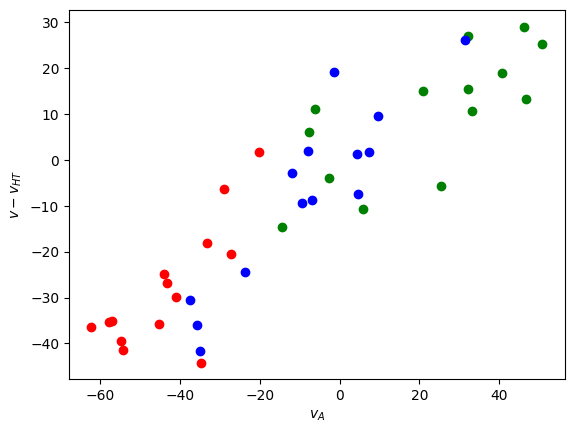

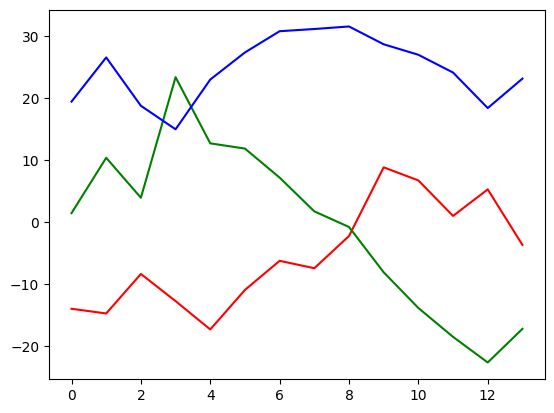

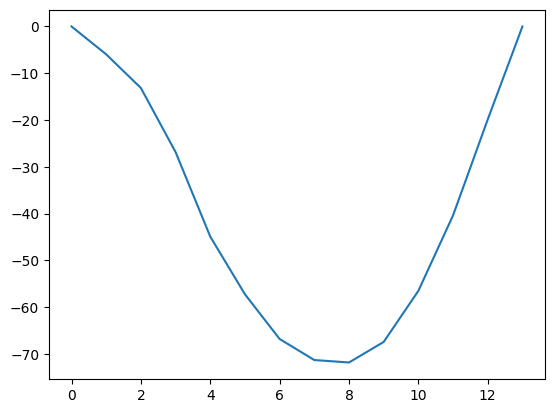

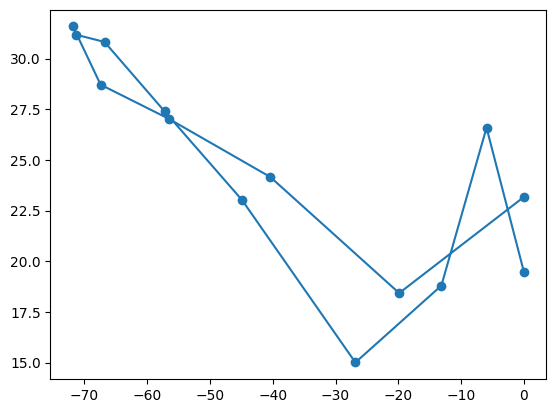

2018-11-13T02:45:30.000000000  to  2018-11-13T02:56:30.000000000
duration: 12
error: 0.096 0.092
walen slope: 0.443
<B>: 31.05
Altitude/azimuth: 70 / 155
Frame quality: 0.9970419585647519
Field-alignedness 0.9509581625461578


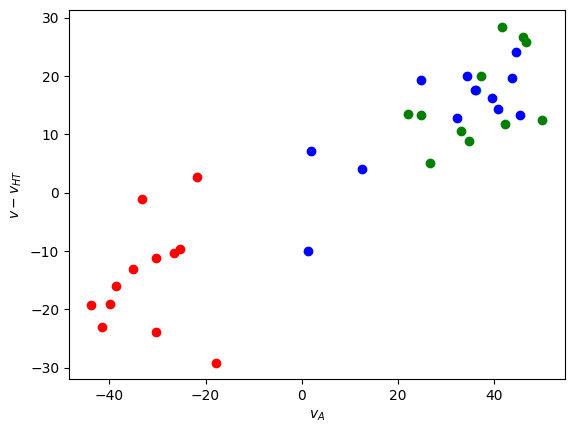

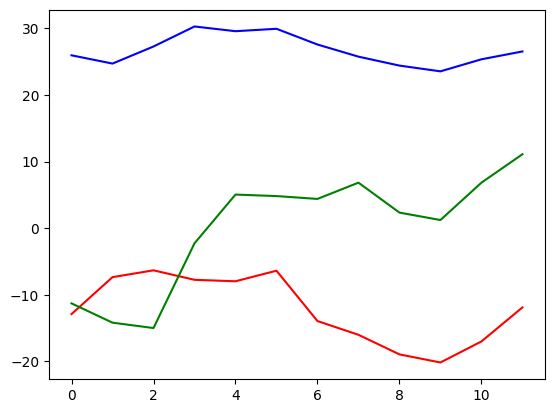

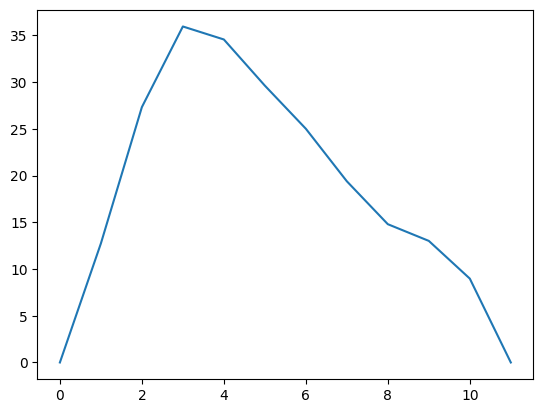

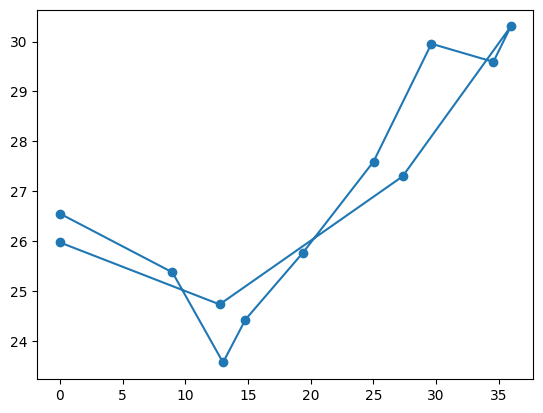

2018-11-13T03:12:30.000000000  to  2018-11-13T03:24:30.000000000
duration: 13
error: 0.096 0.12
walen slope: 0.335
<B>: 32.18
Altitude/azimuth: 46 / 157
Frame quality: 0.994125387173489
Field-alignedness 0.8990717232227325


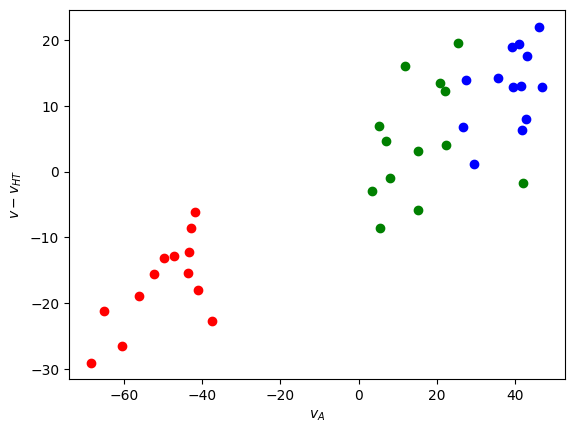

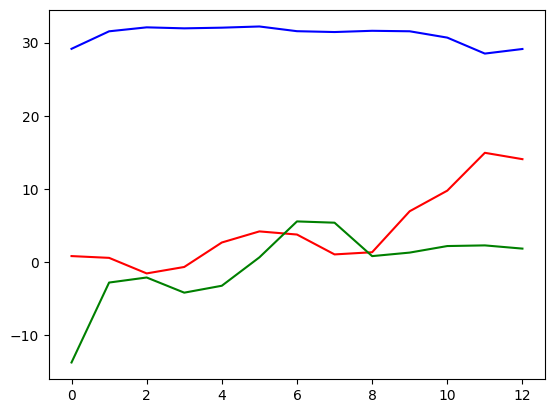

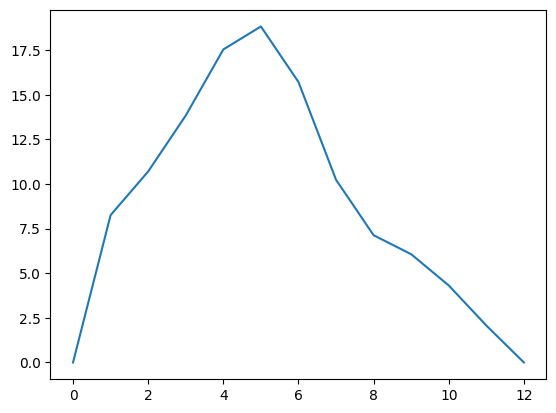

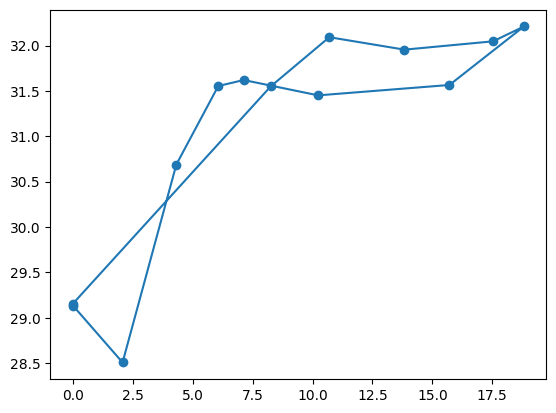

2018-11-13T05:33:30.000000000  to  2018-11-13T06:23:30.000000000
duration: 51
error: 0.095 0.1
walen slope: -0.041
<B>: 27.64
Altitude/azimuth: 87 / 180
Frame quality: 0.9971442366229081
Field-alignedness -0.22727492451667786


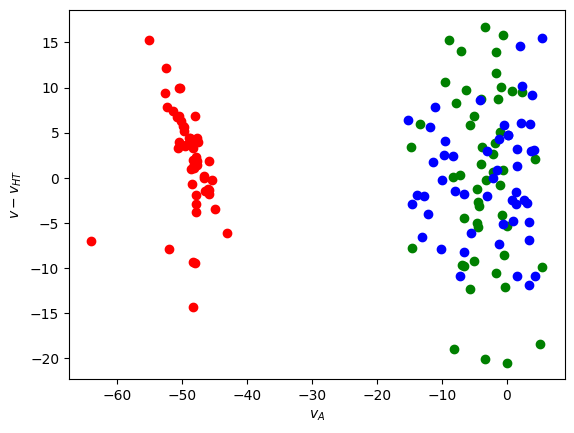

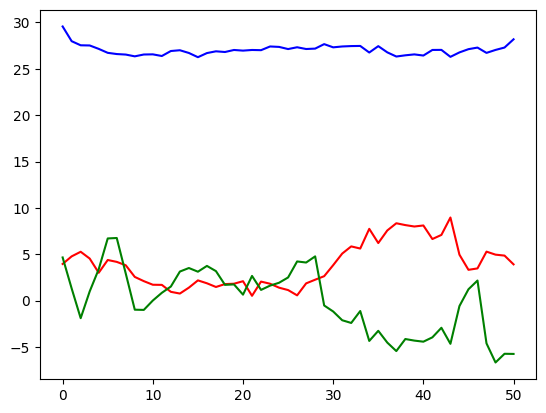

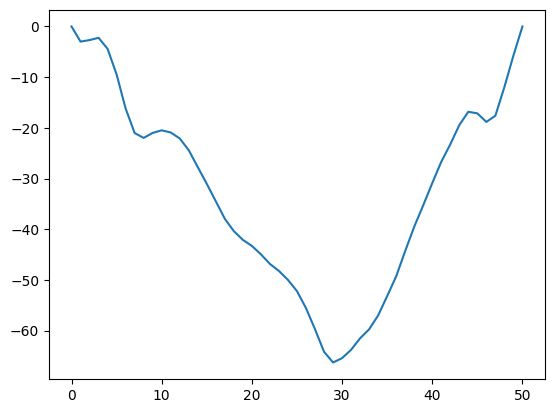

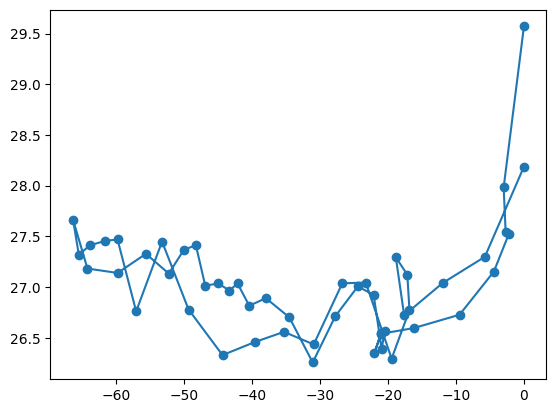

2018-11-13T07:16:30.000000000  to  2018-11-13T07:25:30.000000000
duration: 10
error: 0.104 0.087
walen slope: 0.595
<B>: 30.46
Altitude/azimuth: 62 / 68
Frame quality: 0.9972107582067398
Field-alignedness 0.9902691543102264


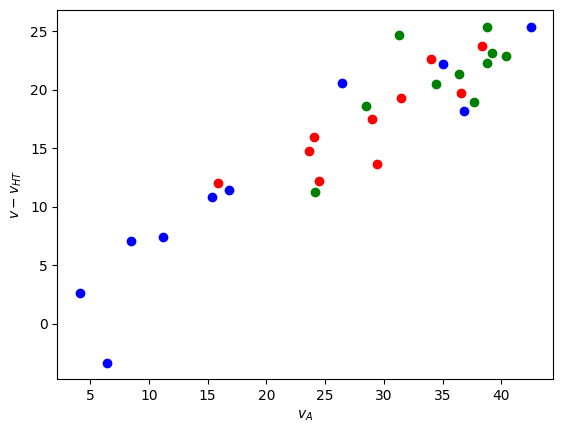

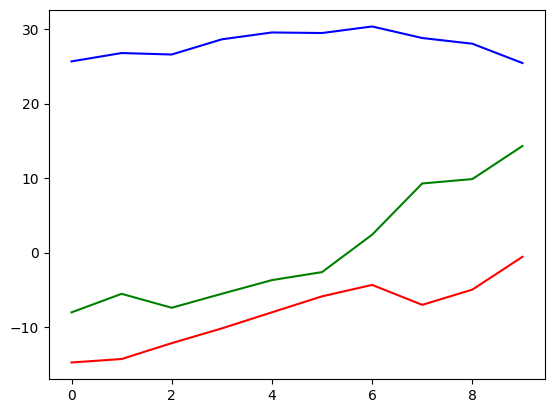

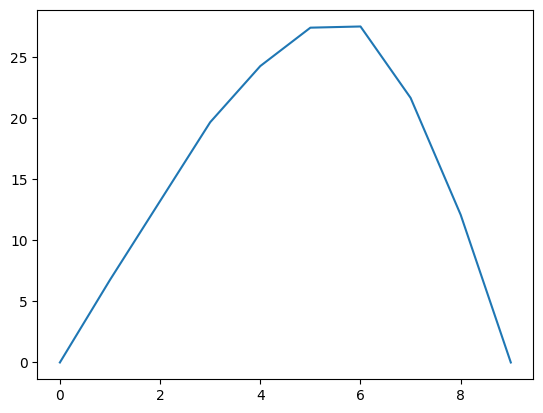

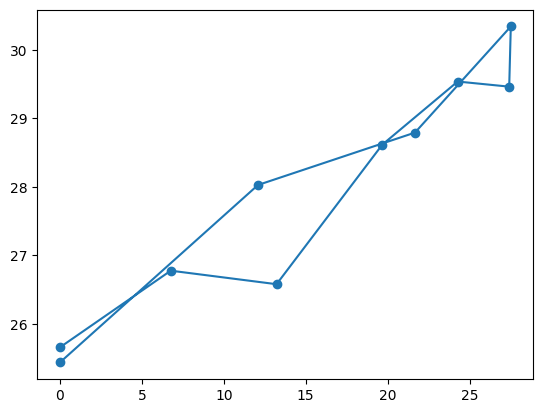

2018-11-13T07:50:30.000000000  to  2018-11-13T08:03:30.000000000
duration: 14
error: 0.107 0.125
walen slope: 0.578
<B>: 30.66
Altitude/azimuth: 52 / 119
Frame quality: 0.9968294000457049
Field-alignedness 0.9817438423633575


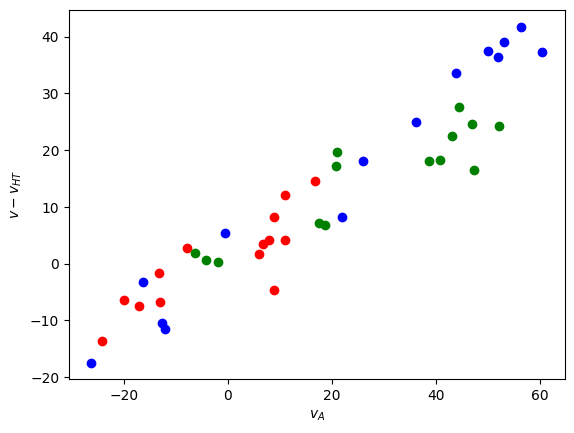

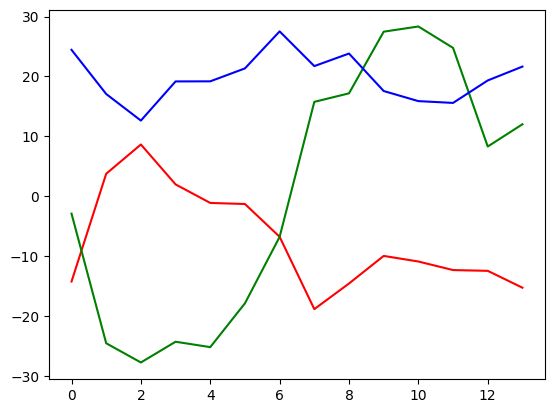

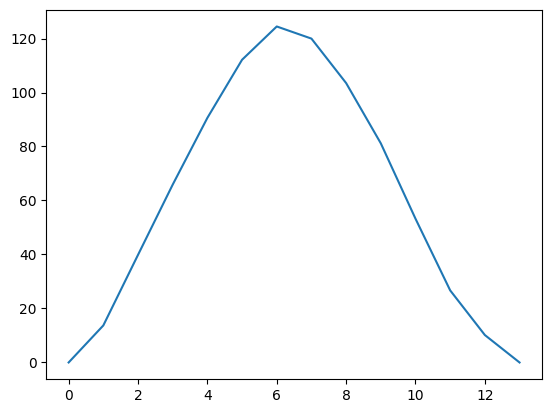

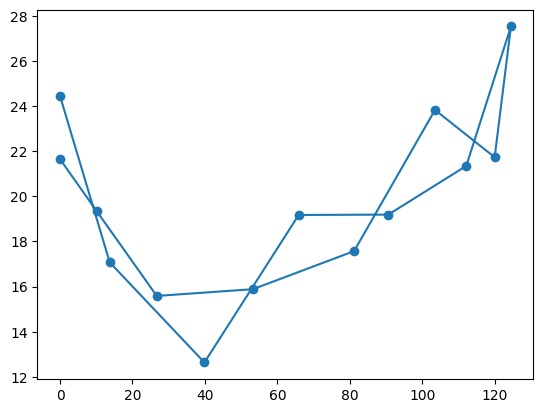

2018-11-13T08:11:30.000000000  to  2018-11-13T08:29:30.000000000
duration: 19
error: 0.103 0.091
walen slope: 0.56
<B>: 33.39
Altitude/azimuth: 21 / 106
Frame quality: 0.9973306618051168
Field-alignedness 0.9687942266464233


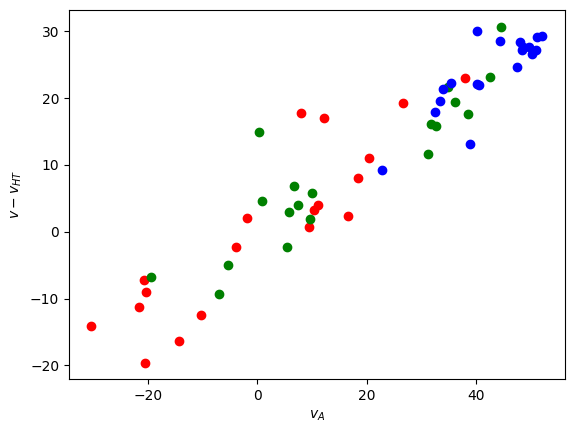

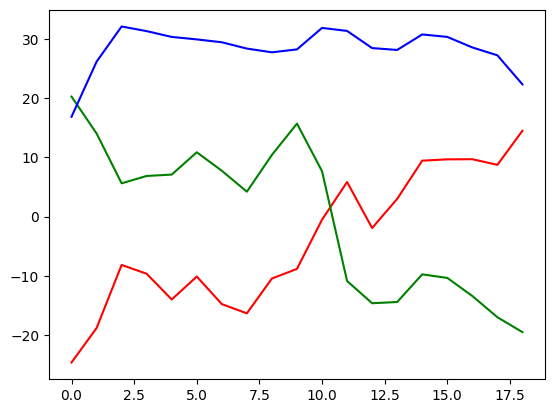

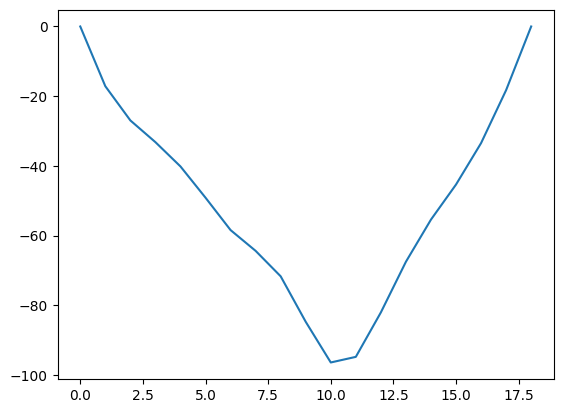

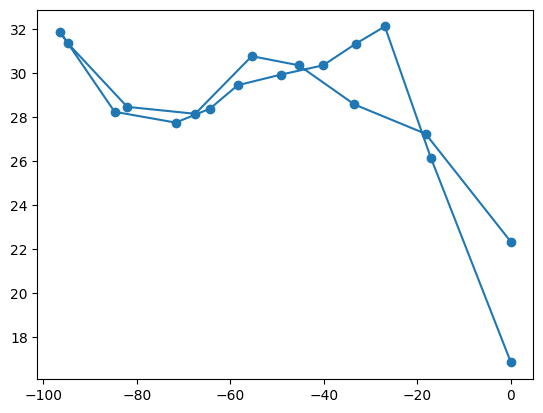

2018-11-13T09:11:30.000000000  to  2018-11-13T09:24:30.000000000
duration: 14
error: 0.081 0.136
walen slope: -0.147
<B>: 33.05
Altitude/azimuth: 90 / 177
Frame quality: 0.9962127898724075
Field-alignedness -0.4914521276950836


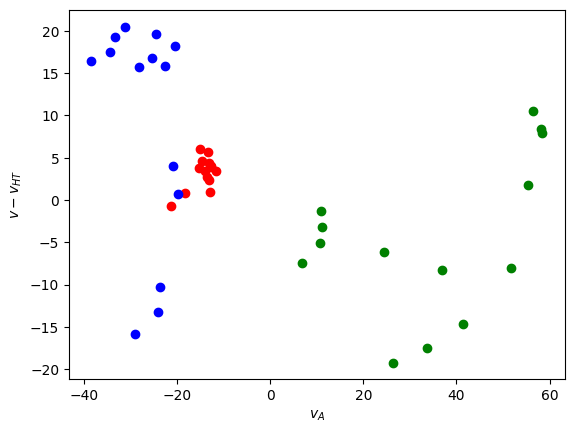

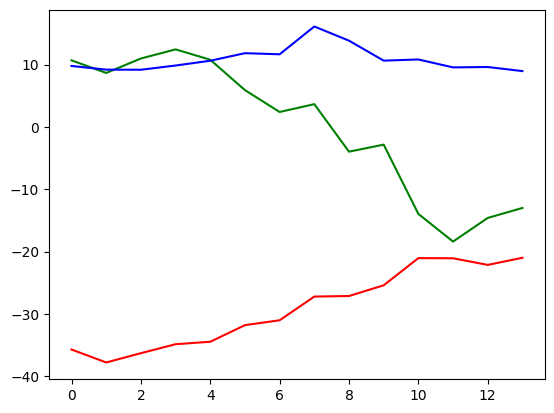

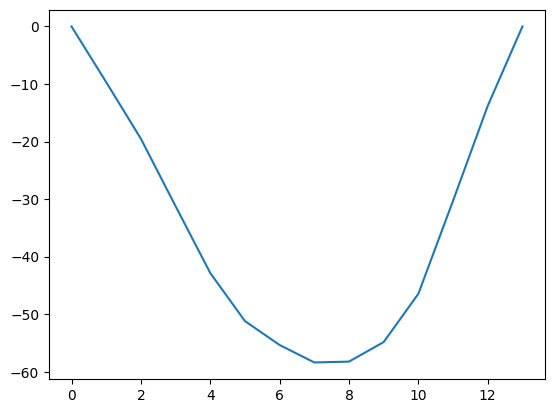

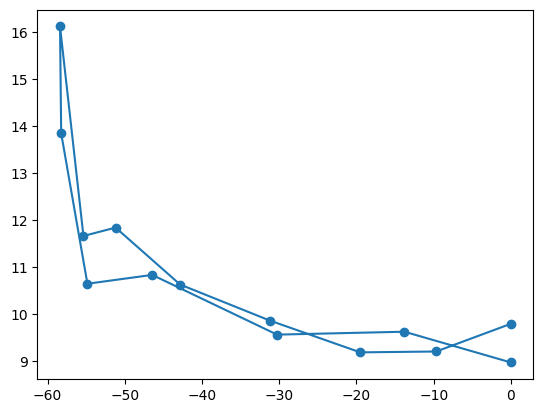

2018-11-13T09:35:30.000000000  to  2018-11-13T11:38:30.000000000
duration: 124
error: 0.095 0.092
walen slope: -0.001
<B>: 29.89
Altitude/azimuth: 49 / 83
Frame quality: 0.9975390243417277
Field-alignedness 0.2542441338300705


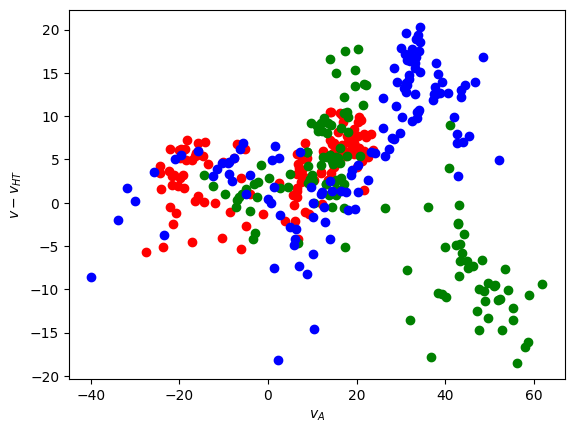

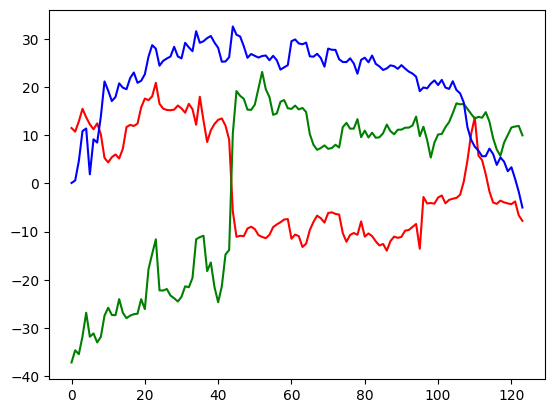

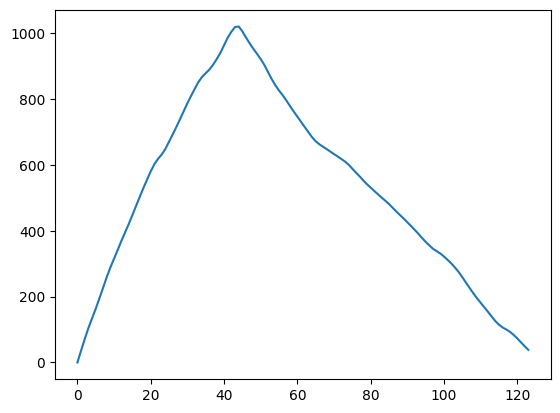

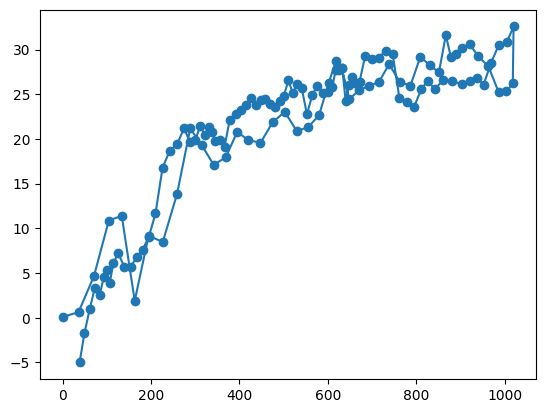

2018-11-13T15:29:30.000000000  to  2018-11-13T15:46:30.000000000
duration: 18
error: 0.105 0.112
walen slope: 0.832
<B>: 32.84
Altitude/azimuth: 98 / 165
Frame quality: 0.9968367926938126
Field-alignedness 0.9753255844116211


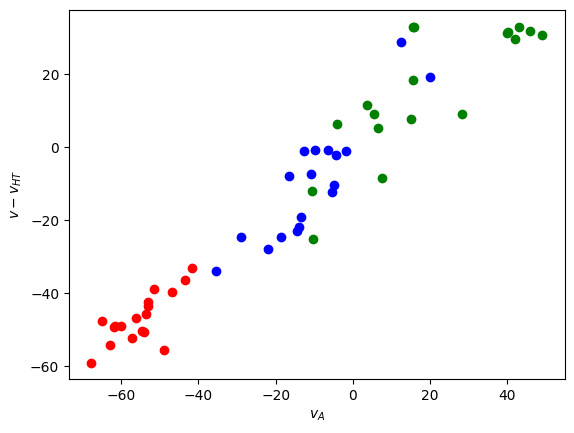

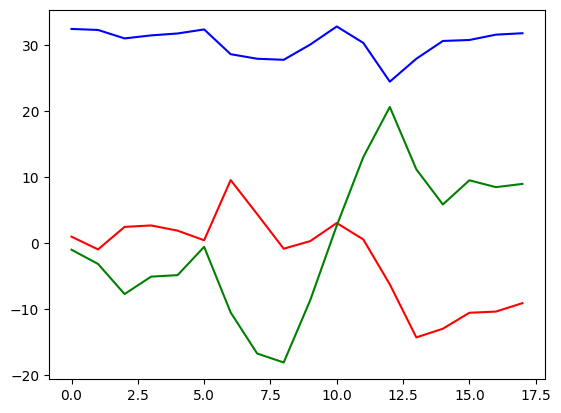

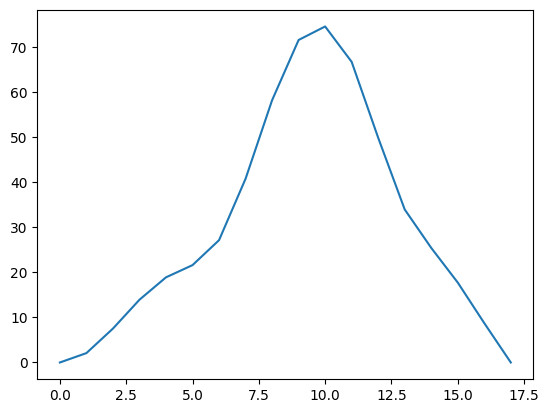

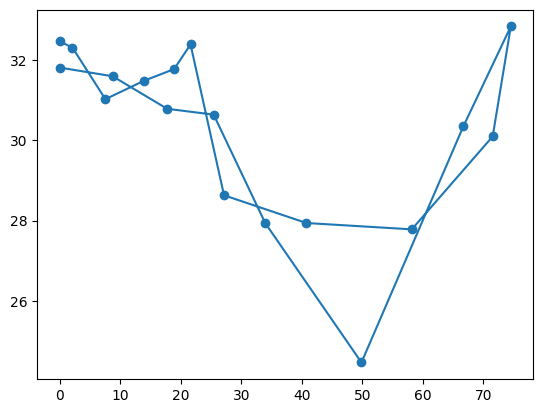

2018-11-13T17:47:30.000000000  to  2018-11-13T18:04:30.000000000
duration: 18
error: 0.112 0.133
walen slope: 0.863
<B>: 26.7
Altitude/azimuth: 49 / 48
Frame quality: 0.9924025157280816
Field-alignedness 0.9827022850513458


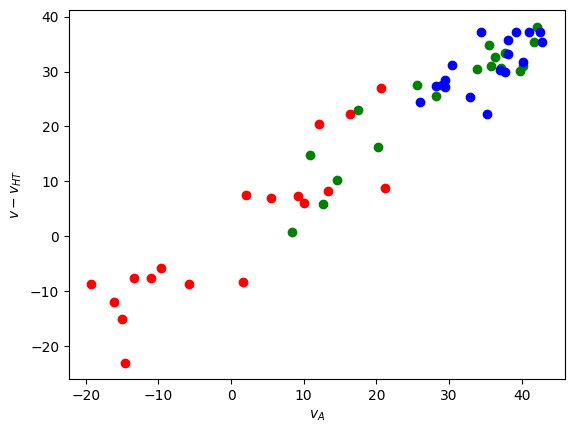

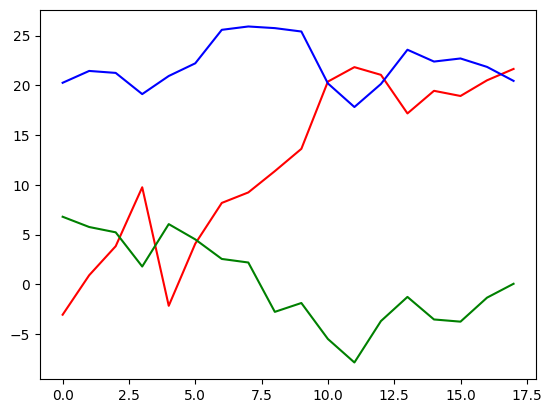

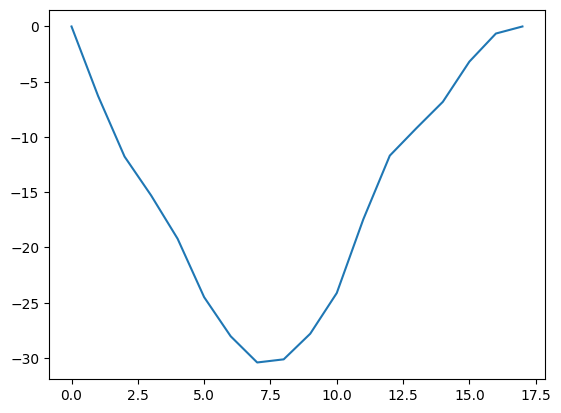

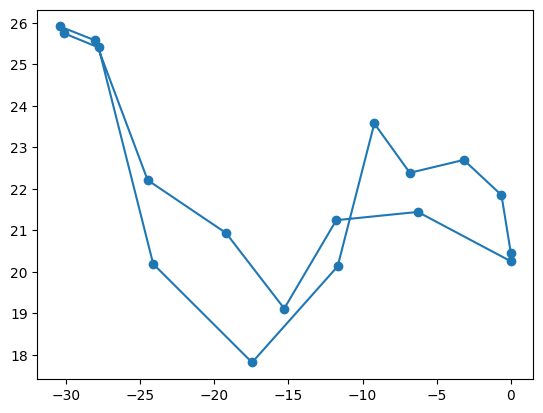

2018-11-13T22:48:30.000000000  to  2018-11-13T23:01:30.000000000
duration: 14
error: 0.103 0.082
walen slope: 0.556
<B>: 28.07
Altitude/azimuth: 62 / 98
Frame quality: 0.9965471425874592
Field-alignedness 0.9814440608024597


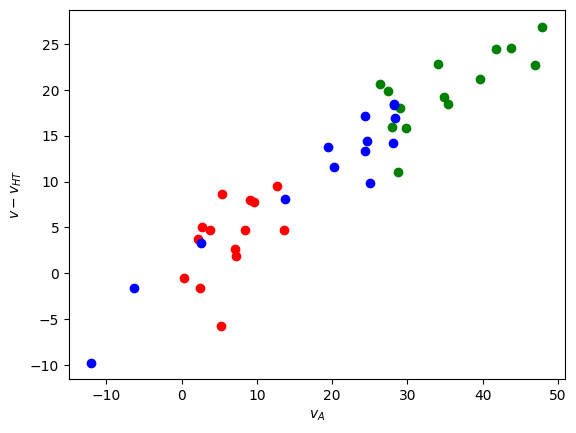

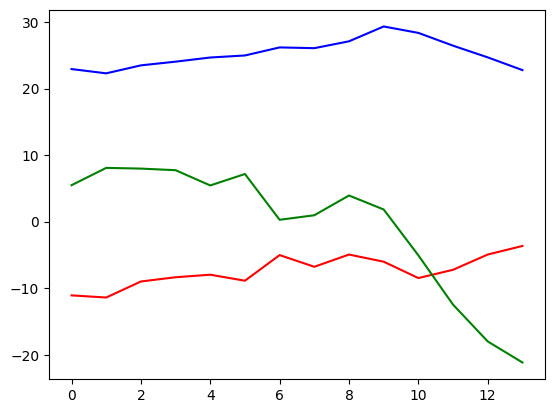

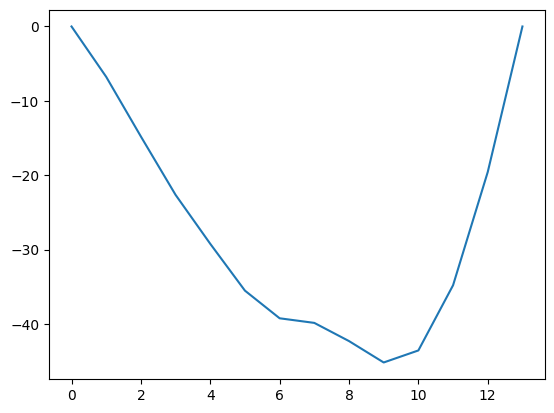

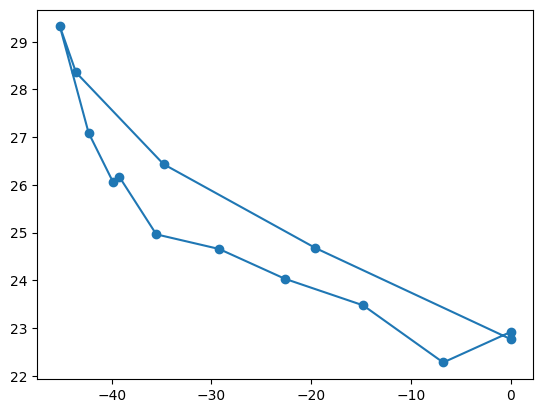

2018-11-13T23:10:30.000000000  to  2018-11-13T23:49:30.000000000
duration: 40
error: 0.071 0.061
walen slope: 0.33
<B>: 25.07
Altitude/azimuth: 61 / 337
Frame quality: 0.9976473490505056
Field-alignedness 0.9724849462509155


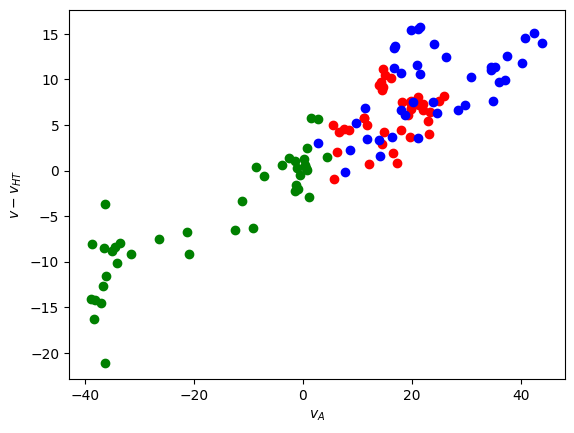

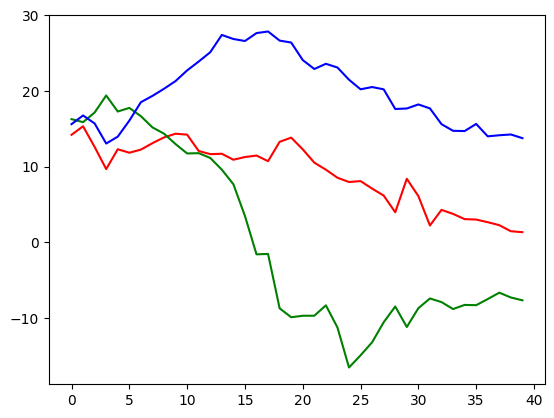

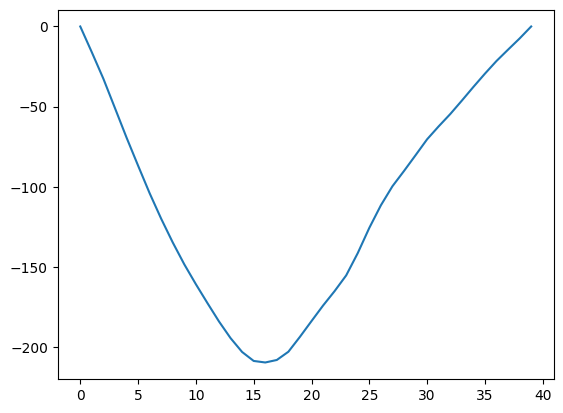

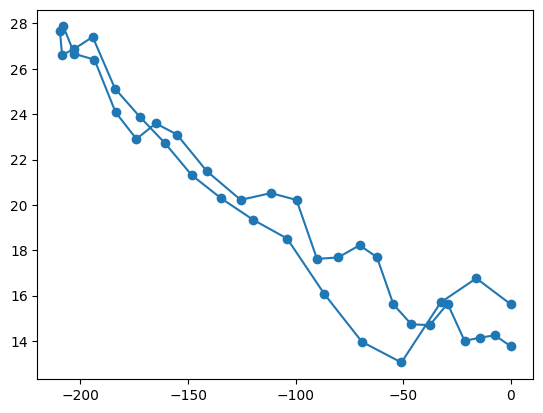

In [5]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for i_result in results.index:
    axis = results[["axis_x", "axis_y", "axis_z"]].iloc[i_result]
    frame = results[["frame_x", "frame_y", "frame_z"]].iloc[i_result]
    start = results.start.iloc[i_result]
    duration = results.duration.iloc[i_result]
    end = results.end.iloc[i_result]
    error_diff = results.error_diff.iloc[i_result]
    error_fit = results.error_fit.iloc[i_result]

    z_unit = np.array(axis)
    frame = np.array(frame)

    event_velocity = velocity[start:start + duration].cpu().numpy()
    event_field = magnetic_field[start:start + duration].cpu().numpy()

    x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(z_unit, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

    event_density = density[start:start + duration].cpu().numpy()

    alfven_velocity = event_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    Pgas = gas_pressure[start:start + duration].cpu().numpy()
    remaining_flow = event_velocity - frame

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    print(times[start], " to ", times[end])
    print("duration:", duration)
    print("error:", round(error_diff, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("<B>:", round(np.linalg.norm(event_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))
    print("Frame quality:", scipy.stats.pearsonr(-np.cross(velocity, magnetic_field).flatten(),
                                                 -np.cross(frame, magnetic_field).flatten())[0])
    print("Field-alignedness", ((remaining_flow / np.linalg.norm(remaining_flow, axis=1)[:, None]) * (event_field / np.linalg.norm(event_field, axis=1)[:, None])).mean() * 3)

    colors = ["red", "green", "blue"]

    for i, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i], remaining_flow[:, i], color=color)
        plt.xlabel(r"$v_A$")
        plt.ylabel(r"$v - v_{HT}$")
    plt.show()


    rotated = rotation_matrix @ event_field.T
    for i_color, color in enumerate(colors):
        plt.plot(rotated[i_color], color=color)
    plt.show()

    dx = np.linalg.norm(np.dot(frame, x_unit))
    A = scipy.integrate.cumulative_trapezoid(-rotated[1], initial=0)
    plt.plot(A)
    plt.show()

    P = Pgas + (rotated[2] * 1e-9) ** 2 / (2 * 1.25663706212e-6) * 1e9
    plt.scatter(A, rotated[2])
    plt.plot(A, rotated[2])
    plt.show()